In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("house-pi/dataset/dataset.csv")
test = pd.read_csv("house-pi/test.csv")
sample_submission = pd.read_csv("house-pi/sample_submission.csv")

In [3]:
target_col = "sale_price"
ID_col = "id"

In [4]:
train = train[train[target_col] < 1_500_000]  # outlier filtreleme

# Tarih dönüşümü
train["sale_date"] = pd.to_datetime(train["sale_date"])
test["sale_date"] = pd.to_datetime(test["sale_date"])
train["sale_year"] = train["sale_date"].dt.year
train["sale_month"] = train["sale_date"].dt.month
test["sale_year"] = test["sale_date"].dt.year
test["sale_month"] = test["sale_date"].dt.month

categorical_cols = [
    "city", "zoning", "subdivision", "present_use", "view_rainier", "view_olympics",
    "view_cascades", "view_territorial", "view_skyline", "view_sound", "view_lakewash",
    "view_lakesamm", "view_otherwater", "view_other", "submarket"
]

# Doldur ve encode et
for col in categorical_cols:
    if col in train.columns:
        train[col] = train[col].astype(str).fillna("missing")
        test[col] = test[col].astype(str).fillna("missing")

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])
test[categorical_cols] = encoder.transform(test[categorical_cols])

In [5]:
full_features = [
    "sale_year", "land_val", "imp_val", "latitude", "sqft",
    "longitude", "sqft_lot", "year_built", "join_year",
    "submarket", "area", "grade", "sale_month", "zoning", "sqft_1"
]

train_clean = train.dropna(subset=full_features + [target_col])
X = train_clean[full_features]
y = train_clean[target_col]
test_X = test[full_features]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
def train_qr_model(alpha):
    model = lgb.LGBMRegressor(
        objective='quantile',
        alpha=alpha,
        learning_rate=0.03,
        n_estimators=300,
        min_child_samples=20,
        max_depth=7
    )
    model.fit(X_train, y_train)
    return model

In [13]:
model_lower = train_qr_model(0.1)
model_upper = train_qr_model(0.9)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 220000.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 152839, number of used features: 15
[LightGBM] [Info] Start training from score 929635.625000


In [ ]:
pi_lower = model_lower.predict(test_X)
pi_upper = model_upper.predict(test_X)

In [14]:
def winkler_score(y_true, lower, upper, alpha=0.1):
    score = []
    for yt, l, u in zip(y_true, lower, upper):
        if l <= yt <= u:
            score.append(u - l)
        else:
            penalty = (2 / alpha) * (l - yt) if yt < l else (2 / alpha) * (yt - u)
            score.append((u - l) + penalty)
    return np.mean(score)

pred_lower_val = model_lower.predict(X_val)
pred_upper_val = model_upper.predict(X_val)
val_score = winkler_score(y_val, pred_lower_val, pred_upper_val)
print("📊 Validation Winkler Score:", val_score)

📊 Validation Winkler Score: 357979.5258494597


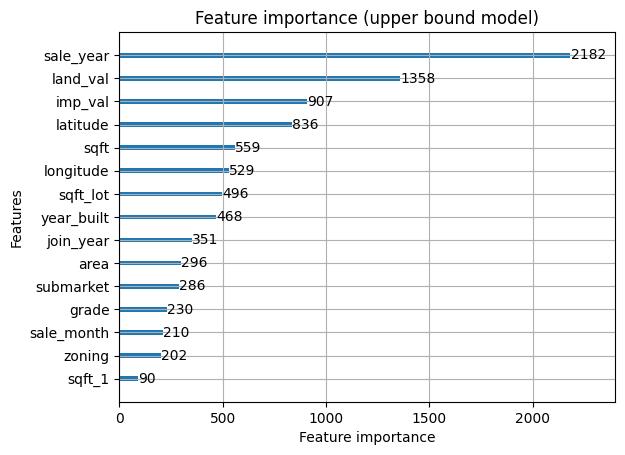

In [15]:
lgb.plot_importance(model_upper, max_num_features=20)
plt.title("Feature importance (upper bound model)")
plt.show()

In [16]:
submission = pd.DataFrame({
    "id": test[ID_col],
    "pi_lower": pi_lower,
    "pi_upper": pi_upper
})

submission.to_csv("submission.csv", index=False)
print("✅ Yeni submission dosyası oluşturuldu.")

✅ Yeni submission dosyası oluşturuldu.
